In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from get_dataset import acsincom

from model import MCLogisticRegression 
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import demographic_parity_difference

#Fairness Analysis
#https://fairlearn.org/main/user_guide/assessment/common_fairness_metrics.html

In [3]:
#income = acsincom(num_data= 1000) # MAX 1664500 #300000
#X_local, y_local, X_global, y_global, sex_global, race_global, state_list  = income.getData()

In [5]:
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split


#shuffle rows
data, _ = arff.loadarff('../dataset/ACSIncome/ACSIncome_state_number.arff')
data = pd.DataFrame(data)

y = (data['PINCP'] > 50000)*1
state_list = data['ST'].unique().tolist()
x = data.drop(['PINCP'], axis=1)

# st_sample_idx = dict()
# for state in state_list:

#     st_sample_idx[state] = [train, test]
    
# x = pd.get_dummies(x, 
#               columns=['COW', 'MAR', 'OCCP','POBP','RELP','SEX','RAC1P'])
x = pd.get_dummies(x, 
              columns=["COW", "SCHL", "MAR","SEX","RAC1P"])
#AGEP, OCCP, POBP, RELP, WKHP
    
sc = StandardScaler()
x = sc.fit_transform(x)


st_data = dict()
for state in state_list:    
    train_idx = data.index[data['ST'] == state].tolist()[0:1000]
    test_idx = data.index[data['ST'] == state].tolist()[1000:3000]
    all_idx = data.index[data['ST'] == state].tolist()[0:3000]
    
    x_sub = x[all_idx]
    sc = StandardScaler()
    x_sub = sc.fit_transform(x_sub)
    
    X_train = x_sub[0:1000]
    X_test = x_sub[1000:3000]
    y_train = y[train_idx].to_numpy()
    y_test = y[test_idx].to_numpy()
    sex_train = data['SEX'][train_idx]
    sex_test = data['SEX'][test_idx]
    race_train = data['RAC1P'][train_idx]
    race_test = data['RAC1P'][test_idx]
    
    st_data[state] = ([X_train, X_test, y_train, y_test,
                       sex_train, sex_test, race_train, race_test] )

# state_list = state.unique().tolist()
# state_list.sort()
# num_each_st = []

# #For Centralized model
# X_all = norm_X
# y_all = y_onehot
# sex_all = np.array(data["SEX"])
# race_all = np.array(data["RAC1P"])
# state_all = []

# #For FedAvg model
# X_st = {}
# y_st = {}
# for st in state_list:
#     st_indices = state.index[state == st]
#     X_st[st] = {"X": norm_X[st_indices],
#                 "sex": np.array(data["SEX"][st_indices]),
#                 "race": np.array(data["RAC1P"][st_indices])}
#     y_st[st] = y_onehot[st_indices]
#     state_all.extend([st]*len(y_onehot[st_indices]))
#     num_each_st.append(len(st_indices))

In [19]:
#Federated Learning.
average_local_testing_acc = []
average_global_testing_acc = []


iteration = 1000
fedavg_weight = None
fedavg_intercept = None

fedavg_local_eod_race = []
fedavg_local_eod_sex = []
fedavg_local_dpr_race = []
fedavg_local_dpr_sex = []

fedavg_global_eod_race = []
fedavg_global_eod_sex = []
fedavg_global_dpr_race = []
fedavg_global_dpr_sex = []

for i in range(iteration):
    weights = []
    intercepts = []
    local_testing_acc = []
    global_testing_acc = []
    
    local_eod_race = []
    local_eod_sex = []
    local_dpr_race = []
    local_dpr_sex = []
    
    global_eod_race = []
    global_eod_sex = []
    global_dpr_race = []
    global_dpr_sex = []
    
    for st in state_list:
        #get only data for the st(state.)
        # X = X_local[st]["X"]
        # sex = X_local[st]["sex"]
        # race = X_local[st]["race"]
        # y = y_local[st]
        
        # X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
        #                         train_test_split(X, y, sex, race, test_size=0.3)
        
        ([X_train, X_test, y_train, y_test,
        sex_train, sex_test, race_train, race_test] ) = st_data[st]  
        
        model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                     0.001, 1, 2, fedavg_weight, 
                                     fedavg_intercept)
        #Training 
        model.train()
        
        #pred for local data
        y_pred = model.predict(X_test)
        local_acc = np.mean(y_pred == y_test)
        weights.append(model.w.tolist())
        intercepts.append(model.b.tolist())
        
        if((i+1) % 20 == 0):
         #local data
            local_testing_acc.append(local_acc)
        
            #Calculate local OE and DP
            local_eod_race_state = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
            local_eod_sex_state = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
            local_dpr_race_state = demographic_parity_difference(y_test,y_pred, sensitive_features=race_test)
            local_dpr_sex_state = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
            
            #Store local OE and DP for each state.
            local_eod_race.append(local_eod_race_state)
            local_eod_sex.append(local_eod_sex_state)
            local_dpr_race.append(local_dpr_race_state)
            local_dpr_sex.append(local_dpr_sex_state)
        
        #global data
            # X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
            #                         train_test_split(X_global, y_global, sex_global, race_global, test_size=0.3)
            # y_pred = model.predict(X_test)
            # global_acc = np.mean(y_pred == y_test)
            # global_testing_acc.append(global_acc)
            
            # #Calculate global OE and DP
            # global_eod_race_state = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
            # global_eod_sex_state = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
            # global_dpr_race_state = demographic_parity_difference(y_test,y_pred, sensitive_features=race_test)
            # global_dpr_sex_state = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
            
            # #Store global OE and DP for each state.
            # global_eod_race.append(global_eod_race_state)
            # global_eod_sex.append(global_eod_sex_state)
            # global_dpr_race.append(global_dpr_race_state)
            # global_dpr_sex.append(global_dpr_sex_state) 
        
    if((i+1) %20 ==0):
        print("iteration", (i+1))
    
    #mean of weights and update the fedavg weights and intercept
    fedavg_weight = np.array(weights).mean(axis=0)
    fedavg_intercept = np.array(intercepts).mean()
    
    if((i+1) % 20 == 0):
    #local
        average_local_testing_acc.append(np.mean(local_testing_acc))
        fedavg_local_eod_race.append(np.mean(local_eod_race))
        fedavg_local_eod_sex.append(np.mean(local_eod_sex))
        fedavg_local_dpr_race.append(np.mean(local_dpr_race))
        fedavg_local_dpr_sex.append(np.mean(local_dpr_sex))
    
    #global
        # average_global_testing_acc.append(np.mean(global_testing_acc))
        # fedavg_global_eod_race.append(np.mean(global_eod_race))
        # fedavg_global_eod_sex.append(np.mean(global_eod_sex))
        # fedavg_global_dpr_race.append(np.mean(global_dpr_race))
        # fedavg_global_dpr_sex.append(np.mean(global_dpr_sex))

iteration 20
iteration 40
iteration 60
iteration 80
iteration 100
iteration 120
iteration 140
iteration 160
iteration 180
iteration 200
iteration 220
iteration 240
iteration 260
iteration 280
iteration 300
iteration 320
iteration 340
iteration 360
iteration 380
iteration 400
iteration 420
iteration 440
iteration 460
iteration 480
iteration 500
iteration 520
iteration 540
iteration 560
iteration 580
iteration 600
iteration 620
iteration 640
iteration 660
iteration 680
iteration 700
iteration 720
iteration 740
iteration 760
iteration 780
iteration 800
iteration 820
iteration 840
iteration 860
iteration 880
iteration 900
iteration 920
iteration 940
iteration 960
iteration 980
iteration 1000


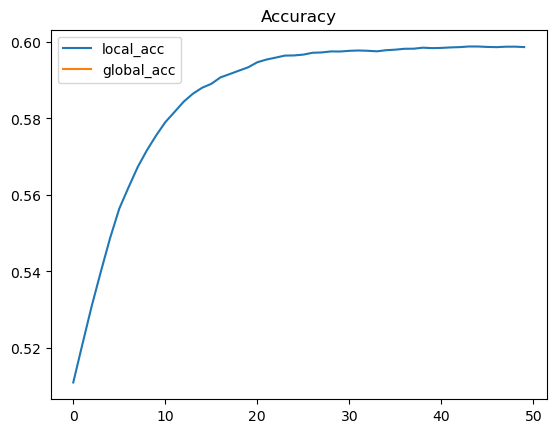

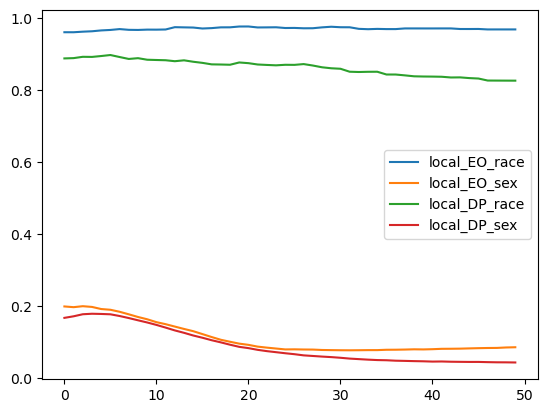

FedAvg local dataset
local_Accuracy 0.598656862745098
local_EO_race 0.9674947947425971
local_EO_sex 0.08522807488290099
local_DP_race 0.82525699156394
local_DP_sex 0.042942160037955056


In [20]:
plt.plot(average_local_testing_acc, label='local_acc')
plt.plot(average_global_testing_acc, label='global_acc')

plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(fedavg_local_eod_race, label='local_EO_race')
plt.plot(fedavg_local_eod_sex, label='local_EO_sex')
plt.plot(fedavg_local_dpr_race,label='local_DP_race')
plt.plot(fedavg_local_dpr_sex,label='local_DP_sex')

# plt.plot(fedavg_global_eod_race, label='global_EO_race')
# plt.plot(fedavg_global_eod_sex, label='global_EO_sex')
# plt.plot(fedavg_global_dpr_race,label='global_DP_race')
# plt.plot(fedavg_global_dpr_sex,label='global_DP_sex')
plt.legend()
plt.show()

print("FedAvg local dataset")
print("local_Accuracy", average_local_testing_acc[-1])
print("local_EO_race", fedavg_local_eod_race[-1])
print("local_EO_sex", fedavg_local_eod_sex[-1])
print("local_DP_race", fedavg_local_dpr_race[-1])
print("local_DP_sex", fedavg_local_dpr_sex[-1])

# print("FedAvg global dataset")
# print("gloabl_Accuracy", average_global_testing_acc[-1])
# print("gloabl_EO_race", fedavg_global_eod_race[-1])
# print("global_EO_sex", fedavg_global_eod_sex[-1])
# print("global_DP_race", fedavg_global_dpr_race[-1])
# print("global_DP_sex", fedavg_global_dpr_sex[-1])

In [ ]:
X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                                train_test_split(X_global, y_global, sex_global, race_global, test_size=0.3)

model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                     0.1, 400, 2)
model.train(eval=True)
y_pred = model.predict(X_test)
acc = np.mean(y_pred == y_test) 

eod_race = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
eod_sex = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
dpr_race = demographic_parity_difference(y_test, y_pred, sensitive_features=race_test)
dpr_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)

print(acc)
print("Centralized")
print("Accuracy", acc)
print("EO_race", eod_race)
print("EO_sex", eod_sex)
print("DP_race", dpr_race)
print("DP_sex", dpr_sex)

plt.plot(model.test_acc)
plt.show()

In [ ]:
local_testing_acc = []
global_testing_acc = []
#testing_acc_array = []

local_eod_race = []
local_eod_sex = []
local_dpr_race = []
local_dpr_sex = []

global_eod_race = []
global_eod_sex = []
global_dpr_race = []
global_dpr_sex = []

for st in state_list:
    #get only data for the st(state.)
    X = X_local[st]["X"]
    sex = X_local[st]["sex"]
    race = X_local[st]["race"]
    y = y_local[st]
    
    unique, counts = np.unique(race, return_counts=True)
    print("state:", st, " min count:", np.min(counts))
    
    X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                            train_test_split(X, y, sex, race, test_size=0.3)
                            
    model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                    0.03, 400, 2) #600
    model.train(eval=True)
    y_pred = model.predict(X_test)
    acc = np.mean(y_pred == y_test)
    
    #local 
    local_testing_acc.append(acc)
    #Calculate OE and DP
    local_eod_race_state = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
    local_eod_sex_state = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
    local_dpr_race_state = demographic_parity_difference(y_test, y_pred, sensitive_features=race_test)
    local_dpr_sex_state = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
    #Store OE and DP for each state.
    local_eod_race.append(local_eod_race_state)
    local_eod_sex.append(local_eod_sex_state)
    local_dpr_race.append(local_dpr_race_state)
    local_dpr_sex.append(local_dpr_sex_state)
    
    #gloabl
    X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                            train_test_split(X_global, y_global, sex_global, race_global, test_size=0.3)
    y_pred = model.predict(X_test)
    acc = np.mean(y_pred == y_test)
    global_testing_acc.append(acc)
    #Calculate OE and DP
    gloabl_eod_race_state = equalized_odds_difference(y_test, y_pred, sensitive_features=race_test)
    global_eod_sex_state = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_test)
    global_dpr_race_state = demographic_parity_difference(y_test, y_pred, sensitive_features=race_test)
    global_dpr_sex_state = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_test)
    #Store OE and DP for each state.
    global_eod_race.append(gloabl_eod_race_state)
    global_eod_sex.append(global_eod_sex_state)
    global_dpr_race.append(global_dpr_race_state)
    global_dpr_sex.append(global_dpr_sex_state)
    

In [ ]:
stantalone_local_acc = np.mean(local_testing_acc)

stantalone_local_eod_race = np.mean(local_eod_race)
stantalone_local_eod_sex = np.mean(local_eod_sex)
stantalone_local_dpr_race = np.mean(local_dpr_race)
stantalone_local_dpr_sex = np.mean(local_dpr_sex)

stantalone_global_acc = np.mean(global_testing_acc)

stantalone_global_eod_race = np.mean(global_eod_race)
stantalone_global_eod_sex = np.mean(global_eod_sex )
stantalone_global_dpr_race = np.mean(global_dpr_race)
stantalone_global_dpr_sex = np.mean(global_dpr_sex)

print("stantalone local dataset")
print("local_Accuracy", stantalone_local_acc)
print("local_EO_race", stantalone_local_eod_race)
print("local_EO_sex", stantalone_local_eod_sex)
print("local_DP_race", stantalone_local_dpr_race)
print("local_DP_sex", stantalone_local_dpr_sex)

print("stantalone global dataset")
print("gloabl_Accuracy", stantalone_global_acc)
print("gloabl_EO_race",stantalone_global_eod_race)
print("global_EO_sex", stantalone_global_eod_sex)
print("global_DP_race", stantalone_global_dpr_race)
print("global_DP_sex", stantalone_global_dpr_sex)

In [ ]:
# for i in range(len(state_list)):
#     plt.plot(local_testing_acc[i])
# plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test, _, sex_test, _, race_test = \
                train_test_split(X_global, y_global, sex_global, race_global, test_size=0.3)
                
clf = LogisticRegression().fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

eod_race = equalized_odds_difference(y_test, y_test_pred, sensitive_features=race_test)
eod_sex = equalized_odds_difference(y_test, y_test_pred, sensitive_features=sex_test)
dpr_race = demographic_parity_difference(y_test, y_test_pred, sensitive_features=race_test)
dpr_sex = demographic_parity_difference(y_test, y_test_pred, sensitive_features=sex_test)

print("Centralized")
print("Accuracy", clf.score(X_test,y_test))
print("EO_Race:", eod_race)
print("EO_Sex: ", eod_sex)
print("DP_Race:", dpr_race)
print("DP_Sex: ", dpr_sex)